In [1]:
import pysam
import os
import sys
directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
has_edits,get_dataframe_from_barcode_dict,get_total_coverage_for_contig_at_position,\
print_read_info, update_coverage_array, add_read_information_to_barcode_dict


# An example on a bam for just one cell barcode (split from the original bam)

### in 10X's bam file, xf=25 means that read is uniquely mapped to a genome, and was used for counting UMI. So we should only look at reads with xf=25 from the 10X bam.

In [2]:
barcode = 'AAACCCAAGATTGCGG'
bampath = '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam'.format(barcode)

In [3]:
samfile = pysam.AlignmentFile(bampath, "rb")

# Full test

In [14]:
from collections import defaultdict
import time
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# TOLERANCES/THRESHOLD FOR FILTERING
max_edit_tolerance = 5
dist_from_end_tolerance = 5
base_quality_threshold = 37
mapping_quality_threshold = 255

# DICTIONARIES TO FILL WITH EDIT INFORMATION
barcode_to_position_to_alts = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict())))) 
contig_lengths_dict = get_contig_lengths_dict(samfile)

# THE HEAVY LIFTING
counts = defaultdict(lambda:0)
coverage_dict = {}
    
contigs = []
for contig in contig_lengths_dict.keys():
    try:
        contig_length = contig_lengths_dict.get(contig)
        position_coverage_tracker_for_contig = np.zeros(contig_length)
        reads_for_contig = samfile.fetch(contig, 0, contig_length)

        for i, read in enumerate(reads_for_contig):
            update_coverage_array(read, position_coverage_tracker_for_contig)

            # READ FILTERING DONE
            error_code = add_read_information_to_barcode_dict(read, contig, barcode_to_position_to_alts)
            if error_code:
                counts[error_code] += 1
            else:
                counts['edited'] += 1

        coverage_dict[contig] = position_coverage_tracker_for_contig
        contigs.append(contig)
    except Exception as e:
        print(contig, e)

Stamp "tag 'MD' not present"


In [26]:
counts

defaultdict(<function __main__.<lambda>()>,
            {'edited': 6589, 'no_edits': 27557, 'deletion': 184})

# BUILD DATATFRAME

In [16]:
example_dataframe = get_dataframe_from_barcode_dict(barcode_to_position_to_alts)
print(len(example_dataframe))

12370


# ADD REFERENCE BASE COUNTS AT POSITION

In [17]:
example_dataframe['coverage'] = example_dataframe.apply(get_total_coverage_for_contig_at_position, args=(coverage_dict,), axis=1)


# FILTER DATAFRAME

12370
5574


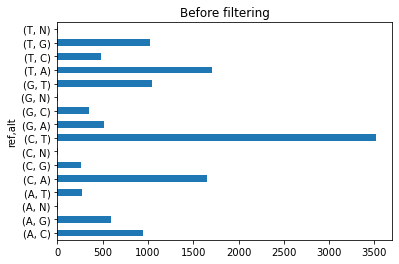

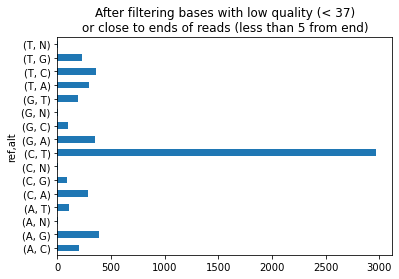

In [18]:
num_edits_per_read = pd.DataFrame(example_dataframe.groupby('read_id').count().barcode)
num_edits_per_read.columns = ['edits']

print(len(example_dataframe))
example_dataframe.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')
plt.title("Before filtering")

"""
plt.figure()
example_dataframe_filtered = example_dataframe[~example_dataframe.read_id.isin(hyperedited_reads.index)]
print(len(example_dataframe_filtered))
example_dataframe_filtered.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')
plt.title("After filtering hyperedited reads (more than {} edits)".format(max_edit_tolerance))
"""

# Filter for distance from read end and base quality
example_dataframe_filtered = example_dataframe[(example_dataframe.dist_from_read_end > dist_from_end_tolerance) & (example_dataframe.quality.astype(int) >= base_quality_threshold)]
print(len(example_dataframe_filtered))
plt.figure()
example_dataframe_filtered.groupby(['ref', 'alt']).count().barcode.plot(kind='barh')
_ = plt.title("After filtering bases with low quality (< {})\nor close to ends of reads (less than {} from end)".format(base_quality_threshold, dist_from_end_tolerance))


In [19]:
example_new_ct =  example_dataframe_filtered[(example_dataframe_filtered.ref == 'C') & (example_dataframe_filtered.alt == 'T')].sort_values('position')

In [20]:
len(example_new_ct)

2972

In [21]:
example_dataframe_filtered

,barcode,contig,position_ref,alt,read_id,strand,dist_from_read_end,quality,ref,position,coverage
32,AAACCCAAGATTGCGG,1,3419869_A,G,A01535:287:H3JJHDSX7:1:1429:7934:26130,-,18,37,A,3419869,1.0
35,AAACCCAAGATTGCGG,1,9942094_C,T,A01535:287:H3JJHDSX7:1:2511:17897:4961,-,15,37,C,9942094,2.0
36,AAACCCAAGATTGCGG,1,10034977_A,G,A01535:287:H3JJHDSX7:1:1265:28203:20776,-,14,37,A,10034977,1.0
37,AAACCCAAGATTGCGG,1,10137689_T,C,A01535:287:H3JJHDSX7:1:1241:22978:17550,-,24,37,T,10137689,4.0
40,AAACCCAAGATTGCGG,1,12860054_C,T,A01535:287:H3JJHDSX7:2:1271:6451:34961,+,25,37,C,12860054,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12359,AAACCCGAGATTGCGG,MT,15041_A,C,A01535:287:H3JJHDSX7:1:1367:30056:8609,+,43,37,A,15041,66.0
12360,ANACCCAAGATTGCGG,2,121458251_C,T,A01535:287:H3JJHDSX7:1:1505:32850:8312,+,22,37,C,121458251,3.0
12361,ANACCCAAGATTGCGG,2,121458274_C,T,A01535:287:H3JJHDSX7:1:1505:32850:8312,+,45,37,C,121458274,3.0
12363,AAACCCAAAATTGCGG,5,33027730_C,T,A01535:287:H3JJHDSX7:1:1346:23773:10629,+,17,37,C,33027730,8.0


# Extract only reads for a barcode

In [22]:
# Get edits for barcode

example = pd.read_csv(
    '../data/group0_data/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam_MD-{}-1.bam.combined.readfiltered.formatted.varfiltered.snpfiltered.ranked.bed'.format(barcode),
    sep='\t', names=['contig', 'start', 'end', 'score', 'coverage', 'strand'])

comparison_vals = []
overlapping_by_contig = {}
for contig in contigs:
    print('contig {}'.format(contig))
    example_new_ct_for_contig = example_new_ct[example_new_ct.contig == contig]
    example_new_ct_for_contig.index = example_new_ct_for_contig.position

    example_old_ct_for_contig = example[example.contig == contig]
    example_old_ct_for_contig.index = example_old_ct_for_contig.start

    # Which overlap?
    
    overlapping = example_old_ct_for_contig.join(example_new_ct_for_contig, rsuffix='_2', how='inner').drop_duplicates(['contig', 'start', 'end', 'score'])
    overlapping['old_coverage'] = [int(v.split(',')[1]) for v in overlapping['coverage']]
    overlapping_by_contig[contig] = overlapping
    print("\tNumber of sites in old version: {}".format(len(example_old_ct_for_contig)))
    print("\tNumber of sites recapitulated: {}".format(len(overlapping)))
    
    comparison_vals.append([len(example_old_ct_for_contig), len(overlapping), len(example_new_ct_for_contig)])


contig 1
	Number of sites in old version: 11
	Number of sites recapitulated: 10
contig 10
	Number of sites in old version: 15
	Number of sites recapitulated: 13
contig 11
	Number of sites in old version: 32
	Number of sites recapitulated: 29
contig 12
	Number of sites in old version: 21
	Number of sites recapitulated: 18
contig 13
	Number of sites in old version: 3
	Number of sites recapitulated: 2
contig 14
	Number of sites in old version: 11
	Number of sites recapitulated: 10
contig 15
	Number of sites in old version: 19
	Number of sites recapitulated: 17
contig 16
	Number of sites in old version: 5
	Number of sites recapitulated: 5
contig 17
	Number of sites in old version: 17
	Number of sites recapitulated: 15
contig 18
	Number of sites in old version: 1
	Number of sites recapitulated: 1
contig 19
	Number of sites in old version: 23
	Number of sites recapitulated: 22
contig 2
	Number of sites in old version: 20
	Number of sites recapitulated: 20
contig 3
	Number of sites in old ver

# Which sites are we recovering?

In [23]:
recapitulation_summary = pd.DataFrame(comparison_vals, index=contigs, columns=['Previous sites', 'Overlapping sites', 'New sites'])

Text(0.5, 1.0, 'Sites from old approach recapitulated with new approach')

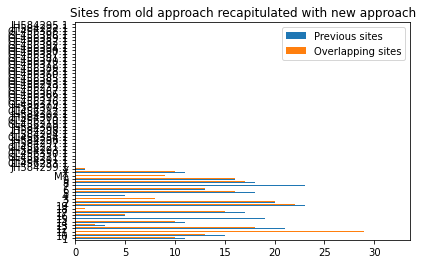

In [24]:
recapitulation_summary[['Previous sites', 'Overlapping sites']].plot(kind='barh')
plt.title("Sites from old approach recapitulated with new approach")

In [25]:
for contig in contigs:
    print(contig)
    corr = overlapping_by_contig.get(contig)[['old_coverage', 'coverage']].corr().iloc[0].iloc[0]
    print('\tCorrelation between old coverage and new coverage values: {}'.format(corr))

1
	Correlation between old coverage and new coverage values: 1.0
10
	Correlation between old coverage and new coverage values: 1.0
11
	Correlation between old coverage and new coverage values: 1.0
12
	Correlation between old coverage and new coverage values: 1.0
13
	Correlation between old coverage and new coverage values: 1.0
14
	Correlation between old coverage and new coverage values: 1.0
15
	Correlation between old coverage and new coverage values: 1.0
16
	Correlation between old coverage and new coverage values: 1.0
17
	Correlation between old coverage and new coverage values: 1.0
18
	Correlation between old coverage and new coverage values: nan
19
	Correlation between old coverage and new coverage values: 1.0
2
	Correlation between old coverage and new coverage values: 1.0
3
	Correlation between old coverage and new coverage values: 1.0
4
	Correlation between old coverage and new coverage values: 1.0
5
	Correlation between old coverage and new coverage values: 1.0
6
	Correlation 